# Imports

In [1]:
from PW_explorer.run_clingo import run_clingo
from PW_explorer.load_worlds import load_worlds
from PW_explorer.pwe_query import PWEQuery
from PW_explorer.pwe_nb_helper import ASPRules
import pandas as pd
import numpy as np
import PW_explorer as pwe

# User Defined Custom Visualization Function

In [2]:
# https://matplotlib.org/gallery/lines_bars_and_markers/timeline.html
from datetime import datetime as datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
def artwork_viz_combined(artwork_df, artist_df, pw_id, start='1825', end='2030'):
    
    artwork_df = artwork_df[artwork_df['pw'] == pw_id]
    artist_df = artist_df[artist_df['pw'] == pw_id]
    artist_color_map = {}
    artist_date_tuples = {}
    artist_artworks = {}
    for i, row in artist_df.iterrows():
        artist_color_map[row['NAME']] = np.random.rand(3,)
        artist_date_tuples[row['NAME']] = (row['BIRTHDATE'], row['DEATHDATE'])
    for i, row in artwork_df.iterrows():
        artist_name = row['ARTIST']
        if artist_name not in artist_artworks:
            artist_artworks[artist_name] = []
        artist_artworks[artist_name].append((row['TITLE'], row['YEAR_PAINTED']))
    
    tags = ['Today']
    dates = ['2019']
    colors = ['g']
    fig, ax = plt.subplots(figsize=(30, 10))
    levels = np.array([-5, 5, -3, 3, -1, 1])
    for artist in artist_color_map.keys():

        birth = artist_date_tuples[artist][0]
        if birth == '-1' or birth == '0':
            birth = '1800'
            #tags.append('Birth Not Known')
        else:
            tags.append("{}'s Birth".format(artist))
            dates.append(birth)
            colors.append('r')
            
        death = artist_date_tuples[artist][1]
        if death == '-1' or death == '0':
            death = '2019'
            #tags.append('Today')
        else:
            tags.append("{}'s Death".format(artist))
            dates.append(death)
            colors.append('r')
        
        if artist in artist_artworks:
            for artwork, date in artist_artworks[artist]:
                
                if date != '-1':
                    dates.append(date)
                    tags.append("{}'s {}".format(artist,artwork))
                    colors.append('b')
        #print(dates)
    
    dates = list(map(lambda date: datetime.strptime(date, '%Y'), dates))
    start = min(min(dates), datetime.strptime(start, '%Y'))
    stop = max(max(dates), datetime.strptime(end, '%Y'))
    ax.plot((start, stop), (0, 0), 'k', alpha=.5)

    for ii, (iname, idate, color) in enumerate(sorted(zip(tags, dates, colors), key=lambda x: x[1])):
        level = levels[ii % 6]
        vert = 'top' if level < 0 else 'bottom'

        ax.scatter(idate, 0, s=100, facecolor='w', edgecolor='k', zorder=9999)
        # Plot a line up to the text
        ax.plot((idate, idate), (0, level), c=color, alpha=.7, linewidth=7)
        # Give the text a faint background and align it properly
        ax.text(idate, level, iname,
                horizontalalignment='right', verticalalignment=vert, fontsize=20,
                backgroundcolor=(1., 1., 1., .3))
    ax.set(title="Timeline for PW-{}".format(pw_id))
    # Set the xticks formatting
    # format xaxis with 3 month intervals
    ax.get_xaxis().set_major_locator(mdates.MonthLocator(interval=120))
    ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%Y"))
    fig.autofmt_xdate()

    # Remove components for a cleaner look
    plt.setp((ax.get_yticklabels() + ax.get_yticklines() +
              list(ax.spines.values())), visible=False)
    #plt.show()
    return fig, ax


# Initial Analysis

#### We first take a look at the original dataset (before data cleaning). We store these rules in the 'clingo_rules' variable as a list of strings

In [3]:
moma_dataset = ASPRules('clingo_files/moma_dataset.lp4')
moma_dataset

'% define artist(NAME, ID, BIRTHDATE, DEATHDATE)\nartist(pablo_picasso, 4609, 1881, 1973).\nartist(artko, 18, 0, 0).\nartist(yayoi_kusama, 3315, 1929, 0).\nartist(picasso, 4609, 1881, 1912).\nartist(kusama, 3315, 1829, 1929).\n\n% define artwork(TITLE, ARTIST, ARTIST_ID, YEAR_PAINTED)\nartwork(seated_woman, pablo_picasso, 4609, 1934).\nartwork(war_and_peace, picasso, 4609, 1955).\nartwork(flower, yayoi_kusama, 3315, 1953).\nartwork(endless, yayoi_kusama, 3315, 1984).\nartwork(accumulation, kusama, 3315, 2027).\nartwork(war, picasso, 4609, 1988).\nartwork(acapulco_gold, artko, 18, 1967).\n%artwork(some_picasso_painting, pablo_picasso, 4609, 1911).\n%artwork(made_up_name, artko, 18, 1855).'

#### Using the run_clingo function, which runs the clingo solver (and also detects the custom %define syntax as can be seen in the clingo program above.), we get 1 PW (as expected since we don't have any constraints yet).

In [4]:
clingo_soln, meta_data = run_clingo(clingo_rules=moma_dataset.splitlines())
ASPRules('\n'.join(clingo_soln))

'Answer: 1\nartist(pablo_picasso,4609,1881,1973) artist(artko,18,0,0) artist(yayoi_kusama,3315,1929,0) artist(picasso,4609,1881,1912) artist(kusama,3315,1829,1929) artwork(seated_woman,pablo_picasso,4609,1934) artwork(war_and_peace,picasso,4609,1955) artwork(flower,yayoi_kusama,3315,1953) artwork(endless,yayoi_kusama,3315,1984) artwork(accumulation,kusama,3315,2027) artwork(war,picasso,4609,1988) artwork(acapulco_gold,artko,18,1967)\nSATISFIABLE\n\nModels       : 1\nCalls        : 1\nTime         : 0.007s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)\nCPU Time     : 0.002s'

#### The meta_data is helpful to name the columns of the Pandas Dataframes that we will create when parsing the solution and other custom syntax that PWE detects.

In [5]:
meta_data

{'attr_defs': {'artist_4': ['NAME', 'ID', 'BIRTHDATE', 'DEATHDATE'],
  'artwork_4': ['TITLE', 'ARTIST', 'ARTIST_ID', 'YEAR_PAINTED']},
 'temporal_decs': {}}

#### From the solution of the above program, we extract the solutions and load the PWs into RDBMS-style Panda Dataframes

In [6]:
pw_rel_dfs, rel_schemas, pw_objs = load_worlds(asp_output=clingo_soln, meta_data=meta_data, reasoner='clingo')

Number of Models: 1


In [7]:
list(map(lambda x: x.__dict__, rel_schemas))

[{'relation_name': 'artist_4',
  'arity': 4,
  'r_id': 0,
  'meta_data': {'attr_defs': ['NAME', 'ID', 'BIRTHDATE', 'DEATHDATE']}},
 {'relation_name': 'artwork_4',
  'arity': 4,
  'r_id': 1,
  'meta_data': {'attr_defs': ['TITLE',
    'ARTIST',
    'ARTIST_ID',
    'YEAR_PAINTED']}}]

#### These are the atom types that were detected. They are stored as "atomName_arity"

In [8]:
pw_rel_dfs.keys()

dict_keys(['artist_4', 'artwork_4'])

This is what the Pandas Dataframe for the 'new_artist' relation (with arity 4) looks like.

In [9]:
pw_rel_dfs['artist_4']

,pw,NAME,ID,BIRTHDATE,DEATHDATE
0,1,pablo_picasso,4609,1881,1973
1,1,artko,18,0,0
2,1,yayoi_kusama,3315,1929,0
3,1,picasso,4609,1881,1912
4,1,kusama,3315,1829,1929


Likewise for the relation 'new_artwork'

In [10]:
pw_rel_dfs['artwork_4']

,pw,TITLE,ARTIST,ARTIST_ID,YEAR_PAINTED
0,1,seated_woman,pablo_picasso,4609,1934
1,1,war_and_peace,picasso,4609,1955
2,1,flower,yayoi_kusama,3315,1953
3,1,endless,yayoi_kusama,3315,1984
4,1,accumulation,kusama,3315,2027
5,1,war,picasso,4609,1988
6,1,acapulco_gold,artko,18,1967


#### We can now visualize this PW using the custom visualization function defined above.

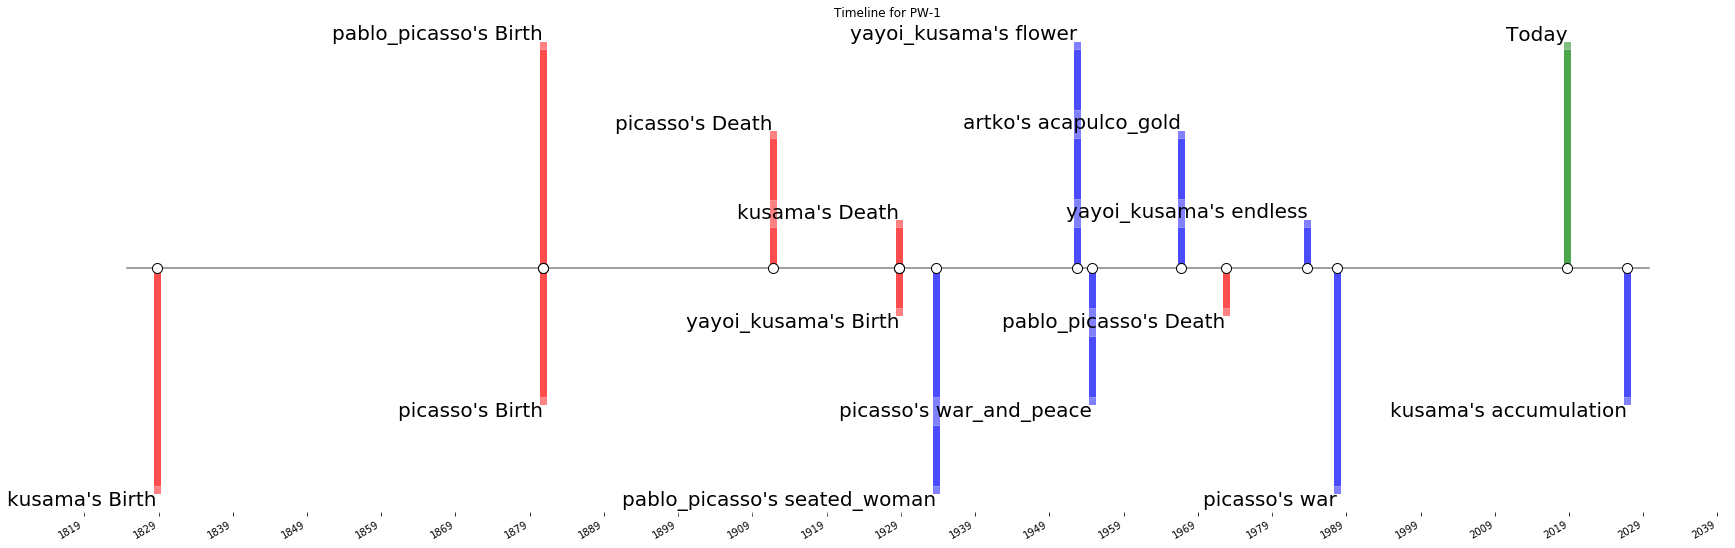

In [12]:
fig, ax = artwork_viz_combined(pw_rel_dfs['artwork_4'], pw_rel_dfs['artist_4'], 1)

And save them in various formats.

In [13]:
# for ftype in ['pdf', 'svg']:
#     fig.savefig(fname='Timeline Visualizations/input.{}'.format(ftype), format=ftype, dpi=1200)
# fig.savefig(fname='Timeline Visualizations/input.{}'.format('png'), format='png')

##### As is evident above, there are a lot of inconsistencies here. For example, there are multiple instances of Picasso and other artists, some artworks are dated in the future, some are dated outside the lifetime of their artist, etc. We must add integrity constraints to detect these, and if possible, fix them.

# Adding the integrity constraints to the ASP

We add these integrity constraints and repair rules.

In [14]:
repair_rules = ASPRules('clingo_files/artwork_db_repair_rules.lp4')
repair_rules

"#const current_year=2019.\n\n% Integrity Constraint Violation for ARTIST_ID (denial):\nicv_PK(ID, NAME1, NAME2, X1, Y1, X2, Y2) :- artist(NAME1, ID, X1, Y1), artist(NAME2, ID, X2, Y2), NAME1 != NAME2.\n\n% Make sure there's exactly one record per ARTIST_ID\ndel_artist(NAME1, ID, X1, Y1) ; del_artist(NAME2,ID, X2,Y2) :- icv_PK(ID,NAME1, NAME2, X1, Y1, X2, Y2).\n\n% Artist DB Repair\n% define new_artist(NAME, ID, BIRTHDATE, DEATHDATE)\nnew_artist(NAME,ID,BD,DD) :- artist(NAME,ID,BD,DD), not del_artist(NAME, ID, BD,DD).\n\n% Keep atleast one artist entry per ID\n:- artist(_, ID, _, _), not new_artist(_, ID, _, _).\n\n% Integrity Constraint Violation: ARTIST_NAME or ARTIST_ID mismatch in the artworks record.\n% define icv_FK(TITLE, ARTIST_ID)\nicv_FK(TITLE, ARTIST_ID) :- artwork(TITLE, ARTIST, ARTIST_ID, YEAR_PAINTED), not new_artist(ARTIST, ARTIST_ID, _, _).\n\n% Adding Date Integrity Constraint Violation Checks: Artwork Date not within Artist's Lifetime\n% define icv_DATE(TITLE)\nicv_DATE(TITLE) :- artwork(TITLE, ARTIST, ARTIST_ID, YEAR), new_artist(NAME, ARTIST_ID, BIRTHDATE, DEATHDATE), YEAR > DEATHDATE, DEATHDATE != 0, DEATHDATE != -1.\nicv_DATE(TITLE) :- artwork(TITLE, ARTIST, ARTIST_ID, YEAR), new_artist(NAME, ARTIST_ID, BIRTHDATE, DEATHDATE), YEAR < BIRTHDATE, BIRTHDATE != -1.\n\n% Adding Integrity Constraint Violation Check: Painting dated in the future\n% define icv_FUTURE(TITLE)\nicv_FUTURE(TITLE) :- artwork(TITLE, ARTIST, ARTIST_ID, YEAR), new_artist(NAME, ARTIST_ID, BIRTHDATE, DEATHDATE), YEAR > current_year.\n\n% Artwork DB Repair\n% Fixing the ARTIST_NAME/ARTIST_ID mismatch error if possible.\n% define new_artwork(TITLE, ARTIST, ARTIST_ID, YEAR_PAINTED)\nnew_artwork(TITLE, ARTIST, ARTIST_ID, YEAR) :- icv_FK(TITLE, ARTIST_ID), artwork(TITLE, W_ARTIST, ARTIST_ID, YEAR), new_artist(ARTIST, ARTIST_ID, _, _), not icv_DATE(TITLE), not icv_FUTURE(TITLE).\n\n% Keeping the artworks with no constraint violations\nnew_artwork(TITLE, ARTIST, ARTIST_ID, YEAR) :- artwork(TITLE, ARTIST, ARTIST_ID, YEAR), not icv_FK(TITLE, ARTIST_ID), not icv_DATE(TITLE), not icv_FUTURE(TITLE)."

And re-run the ASP reasoner, which now gives us 4 PWs or 4 sets of "repairs"

In [15]:
clingo_soln, meta_data = run_clingo(clingo_rules=moma_dataset.splitlines()+repair_rules.splitlines())
ASPRules('\n'.join(clingo_soln))

'Answer: 1\nartist(pablo_picasso,4609,1881,1973) artist(artko,18,0,0) artist(yayoi_kusama,3315,1929,0) artist(picasso,4609,1881,1912) artist(kusama,3315,1829,1929) icv_PK(4609,picasso,pablo_picasso,1881,1912,1881,1973) icv_PK(3315,kusama,yayoi_kusama,1829,1929,1929,0) icv_PK(4609,pablo_picasso,picasso,1881,1973,1881,1912) icv_PK(3315,yayoi_kusama,kusama,1929,0,1829,1929) new_artist(artko,18,0,0) artwork(seated_woman,pablo_picasso,4609,1934) artwork(war_and_peace,picasso,4609,1955) artwork(flower,yayoi_kusama,3315,1953) artwork(endless,yayoi_kusama,3315,1984) artwork(accumulation,kusama,3315,2027) artwork(war,picasso,4609,1988) artwork(acapulco_gold,artko,18,1967) new_artwork(acapulco_gold,artko,18,1967) del_artist(pablo_picasso,4609,1881,1973) del_artist(kusama,3315,1829,1929) new_artist(yayoi_kusama,3315,1929,0) new_artist(picasso,4609,1881,1912) icv_DATE(war) icv_DATE(seated_woman) icv_DATE(war_and_peace) icv_FUTURE(accumulation) icv_FK(seated_woman,4609) icv_FK(accumulation,3315) new_artwork(flower,yayoi_kusama,3315,1953) new_artwork(endless,yayoi_kusama,3315,1984)\nAnswer: 2\nartist(pablo_picasso,4609,1881,1973) artist(artko,18,0,0) artist(yayoi_kusama,3315,1929,0) artist(picasso,4609,1881,1912) artist(kusama,3315,1829,1929) icv_PK(4609,picasso,pablo_picasso,1881,1912,1881,1973) icv_PK(3315,kusama,yayoi_kusama,1829,1929,1929,0) icv_PK(4609,pablo_picasso,picasso,1881,1973,1881,1912) icv_PK(3315,yayoi_kusama,kusama,1929,0,1829,1929) new_artist(artko,18,0,0) artwork(seated_woman,pablo_picasso,4609,1934) artwork(war_and_peace,picasso,4609,1955) artwork(flower,yayoi_kusama,3315,1953) artwork(endless,yayoi_kusama,3315,1984) artwork(accumulation,kusama,3315,2027) artwork(war,picasso,4609,1988) artwork(acapulco_gold,artko,18,1967) new_artwork(acapulco_gold,artko,18,1967) del_artist(pablo_picasso,4609,1881,1973) del_artist(yayoi_kusama,3315,1929,0) new_artist(picasso,4609,1881,1912) new_artist(kusama,3315,1829,1929) icv_DATE(war) icv_DATE(seated_woman) icv_DATE(war_and_peace) icv_DATE(flower) icv_DATE(endless) icv_DATE(accumulation) icv_FUTURE(accumulation) icv_FK(seated_woman,4609) icv_FK(flower,3315) icv_FK(endless,3315)\nAnswer: 3\nartist(pablo_picasso,4609,1881,1973) artist(artko,18,0,0) artist(yayoi_kusama,3315,1929,0) artist(picasso,4609,1881,1912) artist(kusama,3315,1829,1929) icv_PK(4609,picasso,pablo_picasso,1881,1912,1881,1973) icv_PK(3315,kusama,yayoi_kusama,1829,1929,1929,0) icv_PK(4609,pablo_picasso,picasso,1881,1973,1881,1912) icv_PK(3315,yayoi_kusama,kusama,1929,0,1829,1929) new_artist(artko,18,0,0) artwork(seated_woman,pablo_picasso,4609,1934) artwork(war_and_peace,picasso,4609,1955) artwork(flower,yayoi_kusama,3315,1953) artwork(endless,yayoi_kusama,3315,1984) artwork(accumulation,kusama,3315,2027) artwork(war,picasso,4609,1988) artwork(acapulco_gold,artko,18,1967) new_artwork(acapulco_gold,artko,18,1967) del_artist(picasso,4609,1881,1912) del_artist(kusama,3315,1829,1929) new_artist(pablo_picasso,4609,1881,1973) new_artist(yayoi_kusama,3315,1929,0) icv_DATE(war) icv_FUTURE(accumulation) icv_FK(war_and_peace,4609) icv_FK(accumulation,3315) icv_FK(war,4609) new_artwork(seated_woman,pablo_picasso,4609,1934) new_artwork(flower,yayoi_kusama,3315,1953) new_artwork(endless,yayoi_kusama,3315,1984) new_artwork(war_and_peace,pablo_picasso,4609,1955)\nAnswer: 4\nartist(pablo_picasso,4609,1881,1973) artist(artko,18,0,0) artist(yayoi_kusama,3315,1929,0) artist(picasso,4609,1881,1912) artist(kusama,3315,1829,1929) icv_PK(4609,picasso,pablo_picasso,1881,1912,1881,1973) icv_PK(3315,kusama,yayoi_kusama,1829,1929,1929,0) icv_PK(4609,pablo_picasso,picasso,1881,1973,1881,1912) icv_PK(3315,yayoi_kusama,kusama,1929,0,1829,1929) new_artist(artko,18,0,0) artwork(seated_woman,pablo_picasso,4609,1934) artwork(war_and_peace,picasso,4609,1955) artwork(flower,yayoi_kusama,3315,1953) artwork(endless,yayoi_kusama,3315,1984) artwork(accumulation,kusama,3315,2027) artwork(war,picasso,4609,1988) artwork(acapulco_gold,artko,18,1967) new_artwork(aca

We once again load them into Pandas Dataframes

In [16]:
pw_rel_dfs, rel_schemas, pw_objs = load_worlds(asp_output=clingo_soln, meta_data=meta_data, reasoner='clingo')

Number of Models: 4


In [17]:
list(map(lambda x: x.__dict__, rel_schemas))

[{'relation_name': 'artist_4',
  'arity': 4,
  'r_id': 0,
  'meta_data': {'attr_defs': ['NAME', 'ID', 'BIRTHDATE', 'DEATHDATE']}},
 {'relation_name': 'icv_PK_7', 'arity': 7, 'r_id': 1, 'meta_data': {}},
 {'relation_name': 'new_artist_4',
  'arity': 4,
  'r_id': 2,
  'meta_data': {'attr_defs': ['NAME', 'ID', 'BIRTHDATE', 'DEATHDATE']}},
 {'relation_name': 'artwork_4',
  'arity': 4,
  'r_id': 3,
  'meta_data': {'attr_defs': ['TITLE',
    'ARTIST',
    'ARTIST_ID',
    'YEAR_PAINTED']}},
 {'relation_name': 'new_artwork_4',
  'arity': 4,
  'r_id': 4,
  'meta_data': {'attr_defs': ['TITLE',
    'ARTIST',
    'ARTIST_ID',
    'YEAR_PAINTED']}},
 {'relation_name': 'del_artist_4', 'arity': 4, 'r_id': 5, 'meta_data': {}},
 {'relation_name': 'icv_DATE_1',
  'arity': 1,
  'r_id': 6,
  'meta_data': {'attr_defs': ['TITLE']}},
 {'relation_name': 'icv_FUTURE_1',
  'arity': 1,
  'r_id': 7,
  'meta_data': {'attr_defs': ['TITLE']}},
 {'relation_name': 'icv_FK_2',
  'arity': 2,
  'r_id': 8,
  'meta_data':

In [18]:
pw_rel_dfs.keys()

dict_keys(['artist_4', 'icv_PK_7', 'new_artist_4', 'artwork_4', 'new_artwork_4', 'del_artist_4', 'icv_DATE_1', 'icv_FUTURE_1', 'icv_FK_2'])

In [19]:
pw_rel_dfs['new_artist_4']

,pw,NAME,ID,BIRTHDATE,DEATHDATE
0,1,artko,18,0,0
1,1,yayoi_kusama,3315,1929,0
2,1,picasso,4609,1881,1912
3,2,artko,18,0,0
4,2,picasso,4609,1881,1912
5,2,kusama,3315,1829,1929
6,3,artko,18,0,0
7,3,pablo_picasso,4609,1881,1973
8,3,yayoi_kusama,3315,1929,0
9,4,artko,18,0,0


In [20]:
pw_rel_dfs['new_artwork_4']

,pw,TITLE,ARTIST,ARTIST_ID,YEAR_PAINTED
0,1,acapulco_gold,artko,18,1967
1,1,flower,yayoi_kusama,3315,1953
2,1,endless,yayoi_kusama,3315,1984
3,2,acapulco_gold,artko,18,1967
4,3,acapulco_gold,artko,18,1967
5,3,seated_woman,pablo_picasso,4609,1934
6,3,flower,yayoi_kusama,3315,1953
7,3,endless,yayoi_kusama,3315,1984
8,3,war_and_peace,pablo_picasso,4609,1955
9,4,acapulco_gold,artko,18,1967


# Analysis of the 4 repair options

#### We can now visualize these 4 PWs to determine the differences between them

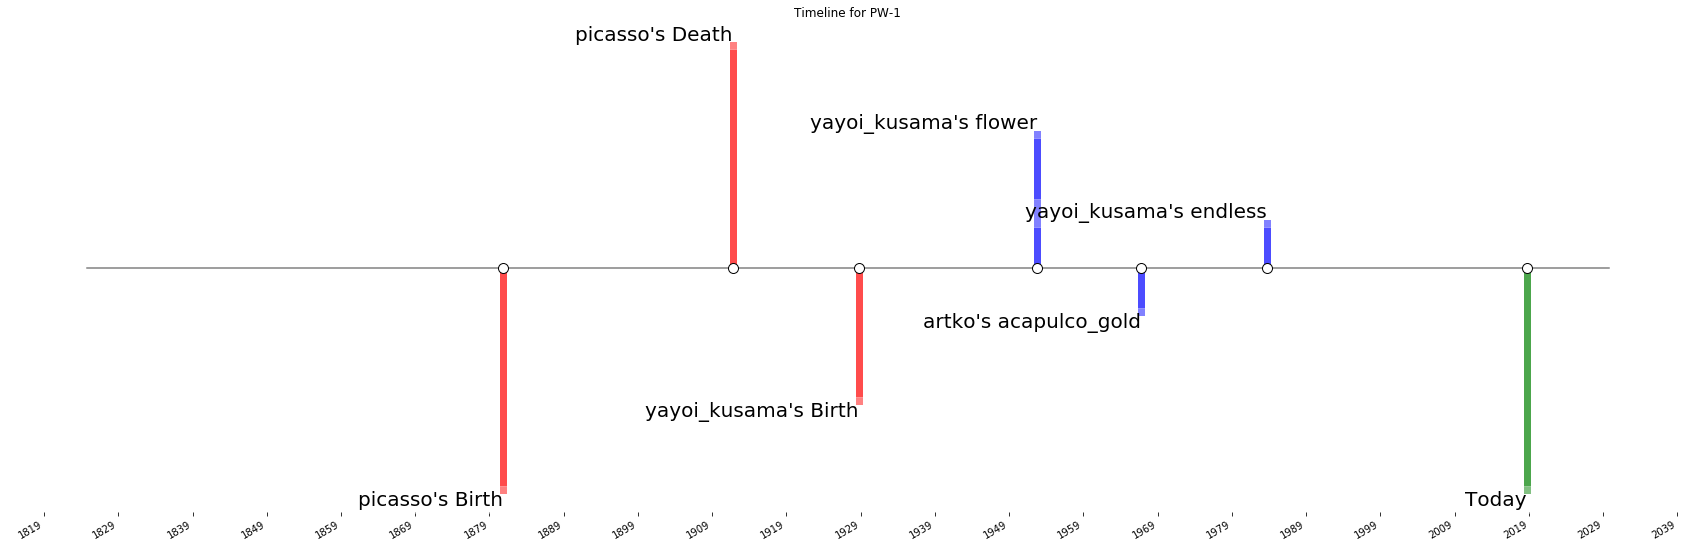

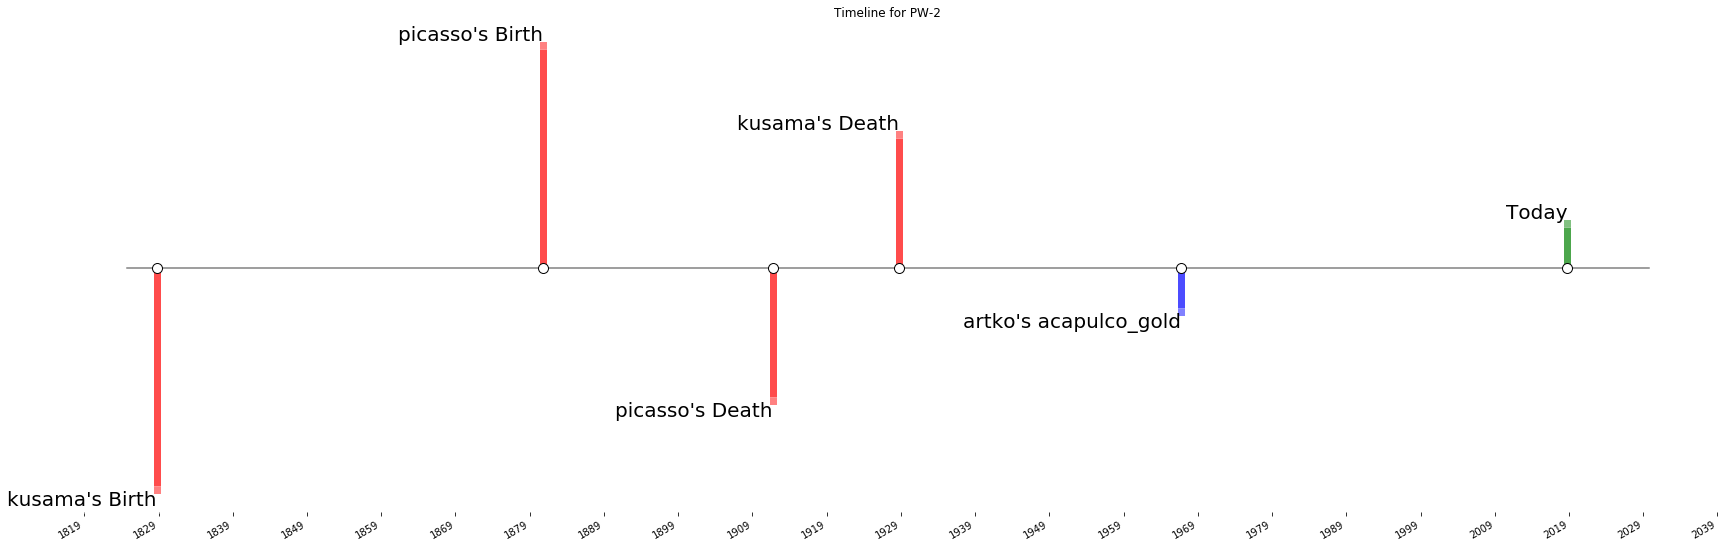

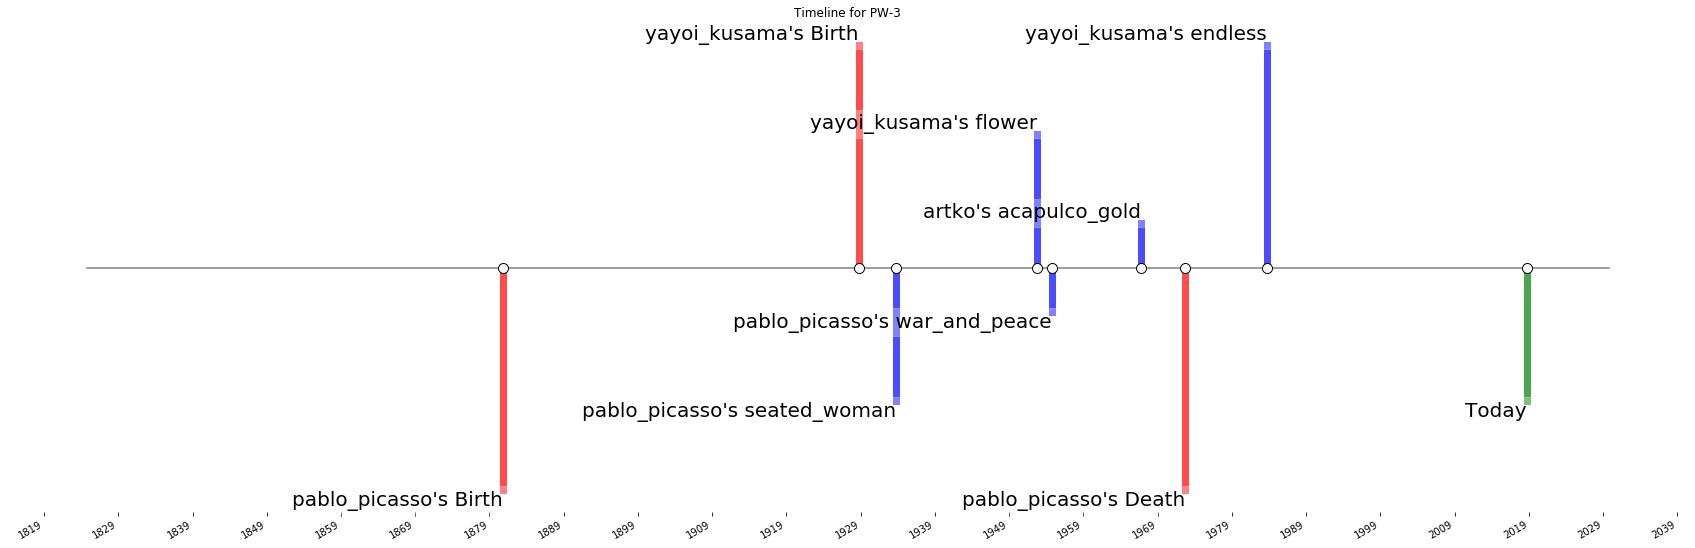

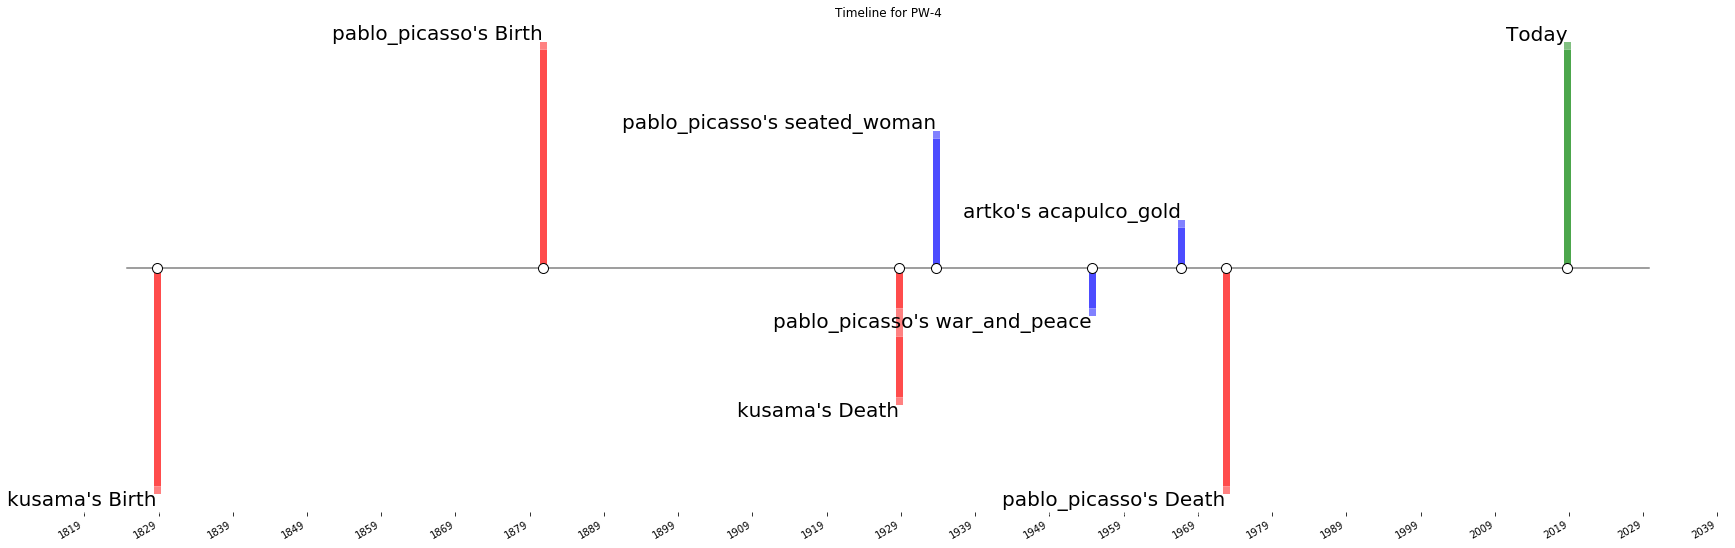

In [21]:
for pw_id in range(1, len(pw_objs)+1):
    fig, ax = artwork_viz_combined(pw_rel_dfs['new_artwork_4'], pw_rel_dfs['new_artist_4'], pw_id)
#     for ftype in ['pdf', 'svg']:
#         fig.savefig('Timeline Visualizations/pw_{}.{}'.format(pw_id, ftype), format=ftype, dpi=1200)
#     fig.savefig('Timeline Visualizations/pw_{}.{}'.format(pw_id, 'png'), format='png')

##### Since the ASP program removes the paintings that do not "fit" the PW, each world ends up with a different set of painting, based on the artist selected in case of duplicate artists, etc. We can find the number of paintings in these PWs as follows

In [22]:
num_paintings = [(pw_id, PWEQuery.num_tuples(dfs=pw_rel_dfs, pw_id=pw_id, rl_name='new_artwork_4')) for pw_id in range(1, len(pw_objs)+1)]
num_paintings

There exist 3 tuples of relation new_artwork_4 in PW 1
There exist 1 tuples of relation new_artwork_4 in PW 2
There exist 5 tuples of relation new_artwork_4 in PW 3
There exist 3 tuples of relation new_artwork_4 in PW 4


[(1, 3), (2, 1), (3, 5), (4, 3)]

#### On sorting them , we see that PW3 has 5 paintings, PW1 has 3 and so on...

In [23]:
num_paintings = sorted(num_paintings, key=lambda x: x[1], reverse=True)
num_paintings

[(3, 5), (1, 3), (4, 3), (2, 1)]

# Choosing a reasonable repair option

##### Assuming the number of errors in the database entry were minimal, the most plausible "repair"/PW must be the one which preserves most paintings (keeps most paintings consistent). That in our case is PW3. (which also turns out to be the PW consistent with the original database (before we added inconsistencies to it)).

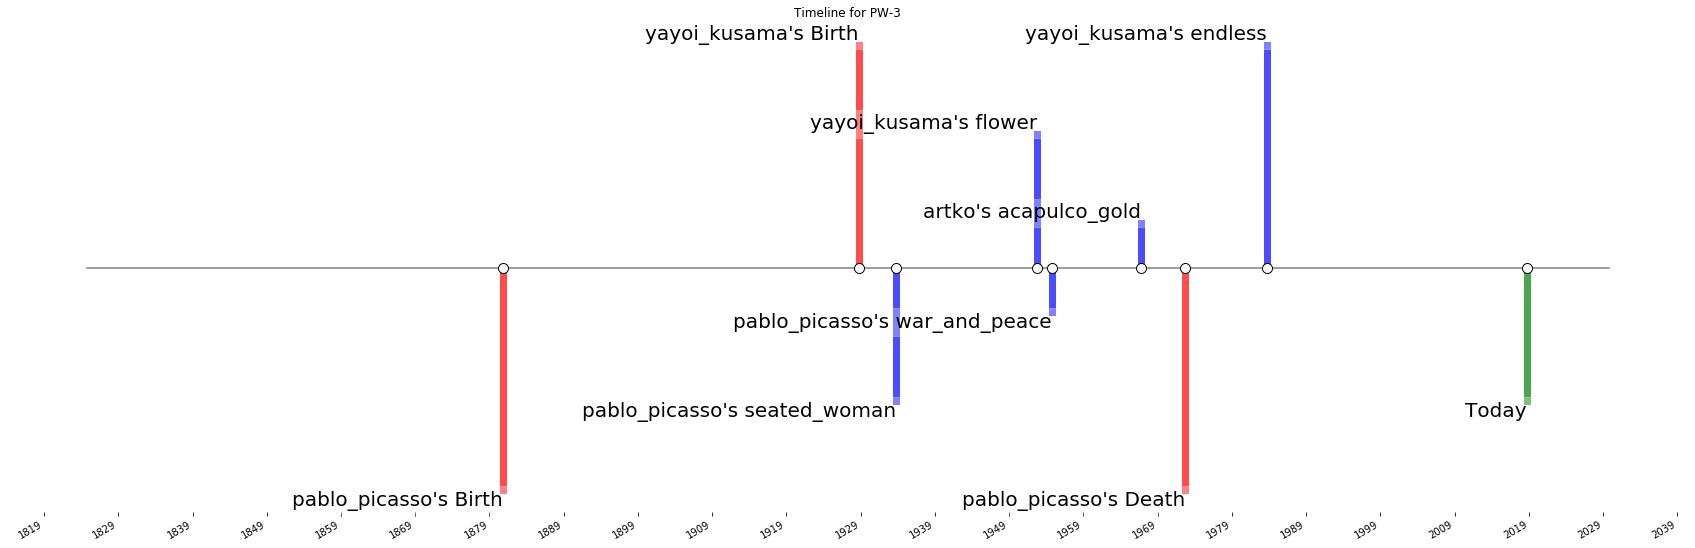

In [24]:
_ = artwork_viz_combined(pw_rel_dfs['new_artwork_4'], pw_rel_dfs['new_artist_4'], num_paintings[0][0])